# Sentinel-5P pitch rotation manoeuvres detection

In the early phase of the Sentinel-5P commissioning, a number of pitch rotation manoeuvres were put in place, in order to perform specific in-flight calibration measurements.  

In this post we are going to try to outline a generalised way in Python to identify the pitch rotations occurring during the set of planned spacecraft manoeuvres. This will allow us to derive manoeuvres execution times and their duration.  

The process under analysis can be considered a special case of a much broader statistical and numerical processing class of problem, called [step detection](https://en.wikipedia.org/wiki/Step_detection), that is the process of finding abrupt changes (steps, jumps, shifts) in the mean level of a time series or signal.

## Loading the data

Let's start by importing our libraries and loading the data from our input data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import dateutil.parser
from datetime import datetime, timedelta
from scipy.signal import savgol_filter
%matplotlib inline

Our data are contained in a Sentinel-5P L1B product, containing both measurements and geolocation/instrument positioning data in a NetCDF4 file.   
Let's open it and extract the variable we are interested in: 
* `solar_elevation_angle`, that is the elevation angle of the sun measured from the instrument, as a function of the scanline.
* `time_reference` and `delta_time`, defining the measurement time for each scanline.

In [3]:
l1b = nc.Dataset('S5P_OFFL_L1B_CA_UVN_20171119T055356_20171119T073526_00523_01_001200_20171119T123144.nc')
measurements = l1b.groups['BAND6_IRRADIANCE'].groups['SOLAR_IRRADIANCE_SPECIAL_MODE_0266']
observations = measurements.groups['OBSERVATIONS']
geodata = measurements.groups['GEODATA']

/Users/stefano/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: WARNING: unsupported Compound type, skipping...
  """Entry point for launching an IPython kernel.


The `solar_elevation_angle` is an array of floats, which identifies the evolution of the elevation angle of the sun, as seen from the instrument, over the scanlines acquired during the orbit.

In [4]:
solar_elevation_angle = geodata.variables['solar_elevation_angle'][0,:]
print(solar_elevation_angle)

[ -3.84181786  -3.82768917  -3.81356263 ...,  34.54127884  34.55457306
  34.56786728]


To determine the measurement time for each scanline, we need to retrieve the reference time, stored as a global attribute in our input file. Then, by using the `delta_time` variable in the `OBSERVATIONS` group, indicating the time difference with respect to the reference time, we will derive the measurement time for each scanline.  

We are going to make use of the `dateutil` module to parse the `time_reference` attribute, which is an UTC time specified as an ISO 8601 date.

In [5]:
time_reference = dateutil.parser.parse(l1b.time_reference)
print("Reference time: {}".format(time_reference))

Reference time: 2017-11-19 00:00:00+00:00


The scanline relative timestamps can be derived by adding the `delta_time` values, expressed as milliseconds from the reference time, to the `time_reference` value.

In [6]:
relatime_timestamps =\
    np.array([time_reference+\
              timedelta(milliseconds=int(observations.variables['delta_time'][0, scanline])) 
              for scanline in range(len(solar_elevation_angle))])

## Plotting the data

Let's have a preliminary look at our solar elevation angle evolution:

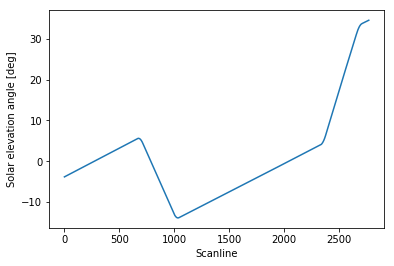

In [7]:
plt.plot(solar_elevation_angle)
plt.xlabel('Scanline')
plt.ylabel('Solar elevation angle [deg]')
plt.show()

The four points where the slope changes identify the spacecraft pitch rotations. As we can see, the solar elevation angle evolution outside the spacecraft manoeuvres regions is pretty much linear as a function of time, and that should always be the case for this particular spacecraft (except for major failures).  

We would like to derive a set of "representative" scanline indexes where the manoeuvres have taken place. Note that during each spacecraft manoeuvre, the slope change is obviously continuous, although discretised in our set of angle values. Therefore, it does not really make sense to try to pick out a single scanline where a manoeuvre has taken place. Our goal is rather to identify, for each manoeuvre, a "representative" scanline in the range of scanlines defining the interval of time where the manoeuvre occurred (e.g. some sort of middle value).

## Filtering and processing the data

My first approach in trying to identify the changes in the curve's slope was to compute the second derivative of the signal, clipping the high-frequency quantisation noise, smoothing the resulting curve with a gaussian filter, and picking the scanlines corresponding to the local maxima in the smoothed signal.  
However, I was not satisfied with this approach, as I had to manually tune the clipping threshold values and the gaussian filter's sigma parameter, to get the scanline indexes I was looking for. As you can imagine, this solution would not easily generalise to other cases.

A much more resilient approach was proposed by [6' white male](https://stackoverflow.com/users/6655984/6-white-male) on this brilliant answer to my [original question on stackoverflow](https://stackoverflow.com/questions/47519626/using-numpy-scipy-to-identify-slope-changes-in-digital-signals), which entails using SciPy's implementation of the [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky–Golay_filter) to smooth out the second derivative of our signal and to consider the regions where the second derivative is "large" enough.

Let's have a look at the filtered signal:

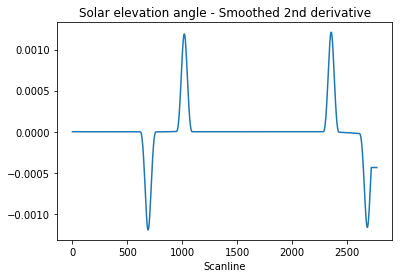

In [8]:
window = 101
filtered_signal = savgol_filter(solar_elevation_angle, window_length=window, 
                                polyorder=2, deriv=2)
plt.plot(filtered_signal)
plt.xlabel('Scanline')
plt.title('Solar elevation angle - Smoothed 2nd derivative')
plt.show()

We want to identify the peaks' indexes. To filter out any residual high-frequency quantisation noise, we are going to consider our peaks as the regions where the signal is greater than half of the absolute maximum value:

In [9]:
peaks = np.where(np.abs(filtered_signal) > np.max(np.abs(filtered_signal))/2)[0]
print(peaks)

[ 659  660  661  662  663  664  665  666  667  668  669  670  671  672  673
  674  675  676  677  678  679  680  681  682  683  684  685  686  687  688
  689  690  691  692  693  694  695  696  697  698  699  700  701  702  703
  704  705  706  707  708  709  710  711  712  713  714  715  716  717  718
  719  989  990  991  992  993  994  995  996  997  998  999 1000 1001 1002
 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017
 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032
 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047
 1048 2326 2327 2328 2329 2330 2331 2332 2333 2334 2335 2336 2337 2338 2339
 2340 2341 2342 2343 2344 2345 2346 2347 2348 2349 2350 2351 2352 2353 2354
 2355 2356 2357 2358 2359 2360 2361 2362 2363 2364 2365 2366 2367 2368 2369
 2370 2371 2372 2373 2374 2375 2376 2377 2378 2379 2380 2381 2382 2383 2384
 2385 2386 2656 2657 2658 2659 2660 2661 2662 2663 2664 2665 2666 2667 2668
 2669 2670 2

We got back a lot of indexes, correctly defining the four different peaks (or half-peaks, to be precise). How to set the peaks apart? We could look at the gaps between them. We define gap as a separation between two adjacent peaks larger than our defined window. For example, in the array above, we can spot a clear gap between 719 and 989, at the beginning of the fifth row.

How to find the gaps in the `peaks` array? The common approach in Python is to use NumPy's `np.diff` function to calculate the discreet difference between the array's values. The output of the `np.diff` function is a new array whose elements are calculated taking the difference between the n+1<sub>th</sub> and the n<sub>th</sub> element of the input array. The length of the returned array is obviously one less of the input array's length. 

In [10]:
np.diff(peaks)

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,  270,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1, 1278,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,   

We can immediately notice a gap of 270 scanline between the first and the second peak, a gap of 1278 scanlines between the second and the third peak, and another gap of 270 scanlines between the third and the fourth peak.  

Our filter did an extremely good job in identifying the correct peaks, but we still want to make sure to pick the correct ones, that is: all gaps separated by a number of scanlines larger than our defined window. For this purpose we are going to define a boolean index array, which will come in handy to retrieve the begin/end indexes of each peak: 

In [12]:
gaps = np.diff(peaks) > window

We can't directly filter our `peaks` array with the `gaps` index array, as the length of the two arrays would not match: remember, `np.diff` returns an array whose size is one less of the input array. But we could slice our `peaks` array in such a way that filtering it with the `gaps` array would return both the beginnings and the ends of each peak.

How does this work?

As an example, let's consider the first identified gap of 270 scanlines in our `np.diff` generated array, and use it to index our `peaks` array.

In [14]:
peaks[np.argwhere(np.diff(peaks) == 270)[0][0]]

719

That's the end of the first gap in our `peak` array. If we "shift" the `peak` array to the left, by taking out the first element, we could then identify the beginning of the next gap: 

In [16]:
peaks[1:][np.argwhere(np.diff(peaks) == 270)[0][0]]

989

Does it start to be clear how we could single out the beginning and ends of each peak?  
Let's then define our peaks' begins and ends as follows:

In [17]:
begins = peaks[1:][gaps]
ends = peaks[:-1][gaps]
print(begins)
print(ends)

[ 989 2326 2656]
[ 719 1048 2386]


Almost there! We need to add the beginning of the first peak to the `begins` array, and the end of the last peak to the `ends` array, which got "lost" during the slicing.

In [18]:
begins = np.insert(begins, 0, peaks[0])
ends = np.append(ends, peaks[-1])
print(begins)
print(ends)

[ 659  989 2326 2656]
[ 719 1048 2386 2714]


Excellent! We have now got the beginning and ends of each of our peaks, or half-peaks to be precise.  
We can then easily derive the middle value as follows:

In [19]:
slop_changes_idx = ((begins + ends)/2).astype(np.int)
print(slop_changes_idx)

[ 689 1018 2356 2685]


Hopefully, those were the scanlines we were looking for.

## Putting all the pieces together 

Let's see how the identified scanlines fit in our plot:

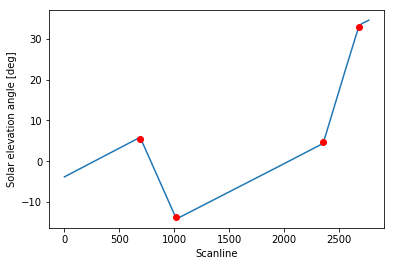

In [21]:
plt.plot(solar_elevation_angle)
plt.plot(slop_changes_idx, solar_elevation_angle[slop_changes_idx], 'ro')
plt.xlabel('Scanline')
plt.ylabel('Solar elevation angle [deg]')
plt.show()

Perfect!

Finding out at what time each pitch manoeuvre occurred is easy as pie. Remember we defined our `relative_timestamps` array containing the measurement time for each scaline? We can now use the `changes` array to index the `relative_timestamps` and retrieve the measurement time for our four scanlines:

In [22]:
relatime_timestamps[slop_changes_idx]

array([datetime.datetime(2017, 11, 19, 7, 11, 56, 512000, tzinfo=tzutc()),
       datetime.datetime(2017, 11, 19, 7, 13, 25, 340000, tzinfo=tzutc()),
       datetime.datetime(2017, 11, 19, 7, 19, 26, 592000, tzinfo=tzutc()),
       datetime.datetime(2017, 11, 19, 7, 20, 55, 420000, tzinfo=tzutc())], dtype=object)

What happens if we apply our good old friend `np.diff` to that `relative_timestamps` slice?  
That's right! We'll get the elapsed time between each of the changes:

In [23]:
print("Manouevres durations: {}".format(
    ", ".join([str(t) for t in np.diff(relatime_timestamps[slop_changes_idx])])))

Manouevres durations: 0:01:28.828000, 0:06:01.252000, 0:01:28.828000


That's some serious NumPy magic going on here!

What about decorating our plot with some fancy labels?

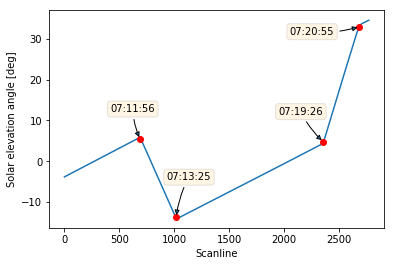

In [26]:
plt.plot(solar_elevation_angle)
plt.plot(slop_changes_idx, solar_elevation_angle[slop_changes_idx], 'ro')

# define relative offset for each label
label_offset = np.array([[15, 25], [35, 35], [0, 25], [-25, -10]])

for i, sl in enumerate(slop_changes_idx):
    plt.annotate("{}".format(relatime_timestamps[sl].strftime("%H:%M:%S")),
                 xy=(slop_changes_idx[i], solar_elevation_angle[slop_changes_idx[i]]), 
                 xycoords='data',
                 xytext=label_offset[i], textcoords='offset points',
                 bbox=dict(boxstyle='round, pad=0.3', fc='orange', alpha=0.1),
                 arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3, rad=0.1"),
                 horizontalalignment='right', verticalalignment='bottom')

plt.xlabel('Scanline')
plt.ylabel('Solar elevation angle [deg]')
plt.show()

Looks great!

That's it for now.  
To summarise: we used a Savitzky–Golay smoothing filter on the second derivative of our variable of interest to identify changes in the slope of the curve. The proposed solution should be robust enough to generalise to similar problems.  
It's been a great learning exercise to dip my toes in the step-detection class of problems.